**Objectives:** Implement linear regression, evaluate performance using  R2  and RMSE, and observe how LASSO/Ridge handle high-dimensional noise.

I am using the California Housing Dataset. The goal is to predict the median house value for California districts.

In [1]:
# 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load data
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target # Target in $100,000s

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Looking for a linear relationship between Median Income and House Value.

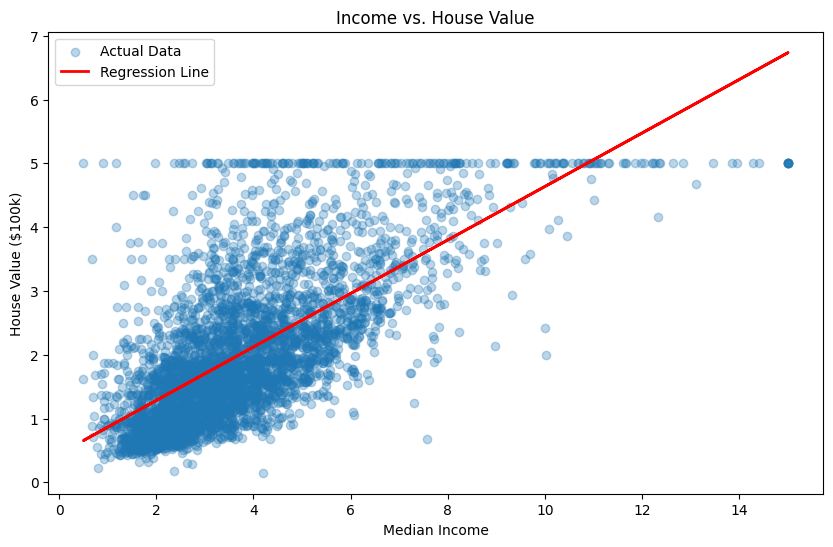

R2 Score (Simple): 0.4589


In [2]:
# 2. Feature selection
X_simple = df[['MedInc']]
y = df['MedHouseVal']

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# 3. Train Model
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

# 4. Predict and Plot
y_pred = simple_model.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, alpha=0.3, label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title("Income vs. House Value")
plt.xlabel("Median Income")
plt.ylabel("House Value ($100k)")
plt.legend()
plt.show()

print(f"R2 Score (Simple): {r2_score(y_test, y_pred):.4f}")

In [3]:
# 3. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('MedHouseVal', axis=1))

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. Fit Multi-Regression
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# 4. Evaluate
multi_pred = multi_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, multi_pred))

print(f"R2 Score (Multi): {r2_score(y_test, multi_pred):.4f}")
print(f"RMSE: ${rmse * 100000:.2f}") # Converting back to actual dollars

R2 Score (Multi): 0.5758
RMSE: $74558.14


Linear (No Penalty): Features used = 28/28 | R2 = 0.5755
Ridge (L2 Penalty): Features used = 28/28 | R2 = 0.5758
Lasso (L1 Penalty): Features used = 3/28 | R2 = 0.4814


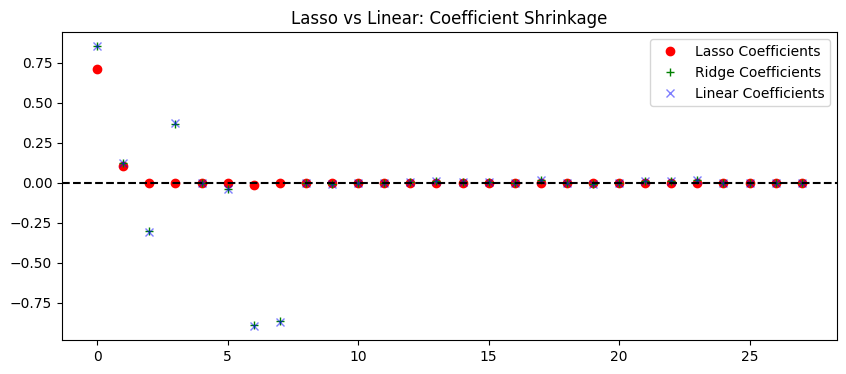

In [4]:
# 4. Add Noise
np.random.seed(42)
noise = np.random.normal(0, 1, (len(X_scaled), 20))
X_noisy = np.hstack([X_scaled, noise])

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

# 2. Compare Models
models = {
    "Linear (No Penalty)": LinearRegression(),
    "Ridge (L2 Penalty)": Ridge(alpha=10),
    "Lasso (L1 Penalty)": Lasso(alpha=0.1)
}

for name, model in models.items():
    model.fit(X_train_n, y_train_n)
    # Count how many coefficients the model actually used (non-zero)
    non_zero = np.sum(model.coef_ != 0)
    print(f"{name}: Features used = {non_zero}/28 | R2 = {model.score(X_test_n, y_test_n):.4f}")

# 3. Visualizing Coefficients
plt.figure(figsize=(10,4))
plt.plot(models["Lasso (L1 Penalty)"].coef_, 'ro', label='Lasso Coefficients')
plt.plot(models["Ridge (L2 Penalty)"].coef_, 'g+', label='Ridge Coefficients')
plt.plot(models["Linear (No Penalty)"].coef_, 'bx', label='Linear Coefficients', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title("Lasso vs Linear: Coefficient Shrinkage")
plt.legend()
plt.show()

In [5]:
import pandas as pd

# Define the alpha values to test
alphas = [0.001, 1, 100]

ridge_results = []
lasso_results = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_n, y_train_n)
    non_zero = np.sum(ridge_model.coef_ != 0)
    ridge_results.append({
        'Model': 'Ridge',
        'Alpha': alpha,
        'Features Used': f"{non_zero}/{X_noisy.shape[1]}",
        'R2 Score': f"{ridge_model.score(X_test_n, y_test_n):.4f}"
    })

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000) # Increased max_iter for convergence
    lasso_model.fit(X_train_n, y_train_n)
    non_zero = np.sum(lasso_model.coef_ != 0)
    lasso_results.append({
        'Model': 'Lasso',
        'Alpha': alpha,
        'Features Used': f"{non_zero}/{X_noisy.shape[1]}",
        'R2 Score': f"{lasso_model.score(X_test_n, y_test_n):.4f}"
    })

ridge_df = pd.DataFrame(ridge_results)
lasso_df = pd.DataFrame(lasso_results)

print("Ridge Regression Results:")
display(ridge_df.style.set_properties(**{'text-align': 'center'}, subset=['Features Used']))

print("\nLasso Regression Results:")
display(lasso_df.style.set_properties(**{'text-align': 'center'}, subset=['Features Used']))

Ridge Regression Results:


,Model,Alpha,Features Used,R2 Score
0,Ridge,0.001000,28/28,0.5755
1,Ridge,1.000000,28/28,0.5755
2,Ridge,100.000000,28/28,0.5777



Lasso Regression Results:


,Model,Alpha,Features Used,R2 Score
0,Lasso,0.001000,23/28,0.5767
1,Lasso,1.000000,0/28,-0.0002
2,Lasso,100.000000,0/28,-0.0002


**Results Interpreted**

**Observation:** As alpha increasesthe R2 score generally decreases, especially for very high alpha values, indicating a strong penalty.

**Interpretation:** For Lasso, as alpha becomes sufficiently high (e.g., 100 in this case), it can set all coefficients to zero (or very close to zero), resulting in an R2 score of 0 or negative.This demonstrates Lasso's feature selection capability where it completely eliminates the influence of certain features, including noise, when the penalty is strong enough.

